# Modules

The purpose of this notebook is to explore a module functionality for JAX.

In [1]:
from flax.core.frozen_dict import FrozenDict, freeze
from jax import numpy as np
from jax import random as jr

from jax.tree_util import register_pytree_node_class
import jax

from contextlib import contextmanager

/Users/collinschlager/miniforge3/envs/ssmjax/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
from modules_beta import Parameter, Module

In [3]:
@register_pytree_node_class
class Linear(Module):
    def __init__(self, in_dim, out_dim, prng_key=jr.PRNGKey(0)):
        super().__init__()
        
        key_1, key_2 = jr.split(prng_key, 2)
        self.W = Parameter(jr.normal(key_1, (in_dim, out_dim)))
        self.b = Parameter(jr.normal(key_2, (out_dim,)))
        
        self.eps = Parameter(np.array([0.03]), is_hyperparameter=True)
        
    def forward(self, x):
        return x @ self.W.value + self.b.value + self.eps.value
    
    @classmethod
    def from_parameters(cls, parameters, hyperparameters):
        """
        Assumes:
            parameters => "W", "b"
            hyperparameters => "eps"
        """
        
        obj = object.__new__(cls)
        super(cls, obj).__init__()
        
        # set the params / hyperparameters
        obj.W = parameters["W"]
        obj.b = parameters["b"]
        obj.eps = hyperparameters["eps"]
        
        return obj

### Displaying Parameters and Hyperparameters

In [4]:
model = Linear(in_dim=3, out_dim=2)
print(model.parameters)
print(model.hyperparameters)

FrozenDict({
    W: <Parameter DeviceArray([[0.59902626, 0.2172144 ],
                 [0.660603  , 0.03266738],
                 [1.2164948 , 1.1940813 ]], dtype=float32) is_hyperparameter=False>,
    b: <Parameter DeviceArray([ 0.19307722, -0.52678293], dtype=float32) is_hyperparameter=False>,
})
FrozenDict({
    eps: <Parameter DeviceArray([0.03], dtype=float32) is_hyperparameter=True>,
})


### Changing Parameters

In [5]:
# first, a test run
x = np.ones((6, 3))
model.forward(x)

DeviceArray([[2.6992013, 0.9471801],
             [2.6992013, 0.9471801],
             [2.6992013, 0.9471801],
             [2.6992013, 0.9471801],
             [2.6992013, 0.9471801],
             [2.6992013, 0.9471801]], dtype=float32)

In [6]:
# set params to zero
model.W = Parameter(np.zeros((3, 2)))
model.b = Parameter(np.zeros((2,)))
model.parameters

FrozenDict({
    W: <Parameter DeviceArray([[0., 0.],
                 [0., 0.],
                 [0., 0.]], dtype=float32) is_hyperparameter=False>,
    b: <Parameter DeviceArray([0., 0.], dtype=float32) is_hyperparameter=False>,
})

In [7]:
x = np.ones((6, 3))
model.forward(x)

DeviceArray([[0.03, 0.03],
             [0.03, 0.03],
             [0.03, 0.03],
             [0.03, 0.03],
             [0.03, 0.03],
             [0.03, 0.03]], dtype=float32)

### Can it JIT?

In [8]:
from jax import jit

@jit
def identity(x):
    return x

In [9]:
model = Linear(in_dim=3, out_dim=2)
model.parameters

FrozenDict({
    W: <Parameter DeviceArray([[0.59902626, 0.2172144 ],
                 [0.660603  , 0.03266738],
                 [1.2164948 , 1.1940813 ]], dtype=float32) is_hyperparameter=False>,
    b: <Parameter DeviceArray([ 0.19307722, -0.52678293], dtype=float32) is_hyperparameter=False>,
})

In [10]:
# yup!
identity(model)

In [11]:
model.parameters

FrozenDict({
    W: <Parameter DeviceArray([[0.59902626, 0.2172144 ],
                 [0.660603  , 0.03266738],
                 [1.2164948 , 1.1940813 ]], dtype=float32) is_hyperparameter=False>,
    b: <Parameter DeviceArray([ 0.19307722, -0.52678293], dtype=float32) is_hyperparameter=False>,
})

# Optimizing Params with Gradients

In [12]:
import optax
from tqdm.auto import tqdm
import copy

In [13]:
@register_pytree_node_class
class Model(Module):
    def __init__(self, a=1.0, b=2.0, c=3.0):
        
        super().__init__()
        
        self.a = Parameter(np.array([a]))
        self.b = Parameter(np.array([b]))
        self.c = Parameter(np.array([c]), is_hyperparameter=True)
        
    @classmethod
    def from_parameters(cls, parameters, hyperparameters):
        obj = object.__new__(cls)
        super(cls, obj).__init__()
        
        # set the params / hyperparameters
        obj.a = parameters["a"]
        obj.b = parameters["b"]
        obj.c = hyperparameters["c"]
        
        return obj
    
    def loss(self, data):
            return ((self.a.value - data[0])**2 + 
                    (self.b.value - data[1])**2 + 
                    (self.c.value - data[2])**2)[0]
        
    def fit(self, data, num_iter=10000):
        
        params = self.parameters
        
        optimizer = optax.adam(1e-3)
        opt_state = optimizer.init(params)

        def objective(params):
            with self.inject(params):
                return self.loss(data)
        
        @jax.jit
        def step(params, opt_state):
            loss_value, grads = jax.value_and_grad(objective)(params)
            updates, opt_state = optimizer.update(grads, opt_state, params)
            params = optax.apply_updates(params, updates)
            return params, opt_state, loss_value
        
        losses = []
        for idx in tqdm(range(num_iter)):
            params, opt_state, loss_value = step(params, opt_state)
            losses.append(loss_value)
            
        self.parameters = params
        return losses

In [14]:
model.parameters

FrozenDict({
    W: <Parameter DeviceArray([[0.59902626, 0.2172144 ],
                 [0.660603  , 0.03266738],
                 [1.2164948 , 1.1940813 ]], dtype=float32) is_hyperparameter=False>,
    b: <Parameter DeviceArray([ 0.19307722, -0.52678293], dtype=float32) is_hyperparameter=False>,
})

In [15]:
model = Model()
model = identity(model)

In [16]:
params = model.parameters

In [17]:
data = np.array([5., 3., 2.])
losses = model.fit(data)

  0%|          | 0/10000 [00:00<?, ?it/s]

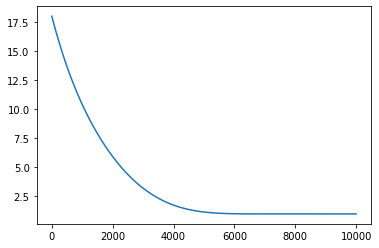

In [18]:
import matplotlib.pyplot as plt
plt.plot(losses)

In [19]:
model.parameters

FrozenDict({
    a: <Parameter DeviceArray([4.9999785], dtype=float32) is_hyperparameter=False>,
    b: <Parameter DeviceArray([2.9999995], dtype=float32) is_hyperparameter=False>,
})

# Nesting Modules

__Need:__ 
- set attribute needs to recognize modules and extract their parameters
- `from_parameters()` needs to nest effectively

In [20]:
@register_pytree_node_class
class DoubleLinear(Module):
    def __init__(self, in_dim, hidden_dim, out_dim, prng_key=jr.PRNGKey(0)):
        super().__init__()
        
        key_1, key_2 = jr.split(prng_key, 2)
        self.linear_1 = Linear(in_dim, hidden_dim, key_1)  # setattr of a module
        self.linear_2 = Linear(hidden_dim, out_dim, key_2) # setattr of a module
        
        self.eps = Parameter(np.array([0.03]), is_hyperparameter=True)
        
    def forward(self, x):
        out = self.linear_1(x)
        out = self.linear_2(out)
        return out
    
    @classmethod
    def from_parameters(cls, parameters, hyperparameters):
        """
        Assumes:
            parameters => "linear_1", "linear_2"
            hyperparameters => "linear_1", "linear_2", "eps"
        """
        
        obj = object.__new__(cls)
        super(cls, obj).__init__()
        
        # set the params / hyperparameters of sub-modules
        # TODO: can you handle this automatically?
        obj.linear_1 = Linear.from_parameters(parameters["linear_1"], hyperparameters["linear_1"])
        obj.linear_2 = Linear.from_parameters(parameters["linear_2"], hyperparameters["linear_2"])
        
        # set the hyperparams of this module
        obj.eps = hyperparameters["eps"]
        
        return obj

In [21]:
model = DoubleLinear(5, 10, 3)

### Test Reconstruction Works

In [22]:
params, hypers = model.parameters, model.hyperparameters

In [23]:
hypers

FrozenDict({
    linear_1: {
        eps: <Parameter DeviceArray([0.03], dtype=float32) is_hyperparameter=True>,
    },
    linear_2: {
        eps: <Parameter DeviceArray([0.03], dtype=float32) is_hyperparameter=True>,
    },
    eps: <Parameter DeviceArray([0.03], dtype=float32) is_hyperparameter=True>,
})

In [24]:
DoubleLinear.from_parameters(params, hypers)

### Does it JIT?

In [25]:
identity(model)

# Scratch Below

(Experimenting with stuff that led to this Issue on distrax: https://github.com/deepmind/distrax/issues/162)

In [26]:
from typing import NamedTuple

In [27]:
import abc
import jax


class Jittable(metaclass=abc.ABCMeta):
  """ABC that can be passed as an arg to a jitted fn, with readable state."""

  def __new__(cls, *args, **kwargs):
    try:
      registered_cls = jax.tree_util.register_pytree_node_class(cls)
    except ValueError:
      registered_cls = cls  # already registered
    instance = super(Jittable, cls).__new__(registered_cls)
    instance._args = args
    instance._kwargs = kwargs
    return instance

  def tree_flatten(self):
    return ((), ((self._args, self._kwargs), self.__dict__))  # children, aux_data

  @classmethod
  def tree_unflatten(cls, aux_data, _):
    (args, kwargs), state_dict = aux_data
    obj = cls(*args, **kwargs)
    obj.__dict__ = state_dict
    return obj

In [28]:
class SubModel(Jittable):
    def __init__(self, a, b, c=np.array([5., 3.])):
        self.a = a
        self.b = b
        self.c = c

In [29]:
class Model(Jittable):
    def __init__(self, a, b, c=np.array([5., 3.])):
        self.a = a
        self.b = b
        self.c = c
        self.submodel = SubModel(a, b, c)

In [30]:
@jit
def identity(x):
    print("jitting...")
    return x

In [31]:
!pip install distrax

In [32]:
from jax import jit
from jax import numpy as jnp
import distrax

# say we have some data
data = jnp.zeros(5)

# and we have a (jittable) function we want to use
# to evaluate our model against that data
@jit
def log_prob(model, data):
    print("jitting...")
    return model.log_prob(data)

# say we have two models we want to compare
# note that the models have the same parameter shapes 

model_1_probs = jnp.ones(5) / 5
bern_1 = distrax.Bernoulli(probs=model_1_probs)  # Note: Bernoulli is a Jittable

model_2_probs = jnp.arange(5)
model_2_probs /= model_2_probs.sum()
bern_2 = distrax.Bernoulli(probs=model_2_probs)

# let's run our func using bern_1 model! since this is
# the first time running, it should JIT compile 
# (i.e. print statement should run)
log_prob(bern_1, data)
print("Done!")

# re-run the compiled function as a sanity check
log_prob(bern_1, data)
print("Done!")

# great, now that's compiled so we should be able to run it
# again on another bern model with same shape (bern_2)
log_prob(bern_2, data)

jitting...
Done!
Done!


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
%debug

> /Users/collinschlager/miniforge3/envs/ssmjax/lib/python3.9/site-packages/jax/_src/device_array.py(41)_forward_method()
     39 
     40 def _forward_method(attrname, self, fun, *args):
---> 41   return fun(getattr(self, attrname), *args)
     42 _forward_to_value = partial(_forward_method, "_value")
     43 



ipdb>  p fun


<class 'bool'>


ipdb>  getattr(self, attrname)


array([False, False,  True, False, False])


ipdb>  *args


*** SyntaxError: can't use starred expression here


ipdb>  args


attrname = '_value'
self = DeviceArray([False, False,  True, False, False], dtype=bool)
fun = <class 'bool'>
args = ()


ipdb>  up


> /Users/collinschlager/miniforge3/envs/ssmjax/lib/python3.9/functools.py(387)_method()
    385         def _method(cls_or_self, /, *args, **keywords):
    386             keywords = {**self.keywords, **keywords}
--> 387             return self.func(cls_or_self, *self.args, *args, **keywords)
    388         _method.__isabstractmethod__ = self.__isabstractmethod__
    389         _method._partialmethod = self



ipdb>  up


> /var/folders/kc/slznj52d4p57wn5mdxm530080000gn/T/ipykernel_42091/2840345409.py(39)<cell line: 39>()
     35 print("Done!")
     36 
     37 # great, now that's compiled so we should be able to run it
     38 # again on another bern model with same shape (bern_2)
---> 39 log_prob(bern_2, data)



ipdb>  down


> /Users/collinschlager/miniforge3/envs/ssmjax/lib/python3.9/functools.py(387)_method()
    385         def _method(cls_or_self, /, *args, **keywords):
    386             keywords = {**self.keywords, **keywords}
--> 387             return self.func(cls_or_self, *self.args, *args, **keywords)
    388         _method.__isabstractmethod__ = self.__isabstractmethod__
    389         _method._partialmethod = self



ipdb>  down


> /Users/collinschlager/miniforge3/envs/ssmjax/lib/python3.9/site-packages/jax/_src/device_array.py(41)_forward_method()
     39 
     40 def _forward_method(attrname, self, fun, *args):
---> 41   return fun(getattr(self, attrname), *args)
     42 _forward_to_value = partial(_forward_method, "_value")
     43 



ipdb>  up


> /Users/collinschlager/miniforge3/envs/ssmjax/lib/python3.9/functools.py(387)_method()
    385         def _method(cls_or_self, /, *args, **keywords):
    386             keywords = {**self.keywords, **keywords}
--> 387             return self.func(cls_or_self, *self.args, *args, **keywords)
    388         _method.__isabstractmethod__ = self.__isabstractmethod__
    389         _method._partialmethod = self



ipdb>  self.func


functools.partial(<function _forward_method at 0x10e135160>, '_value')


ipdb>  q


In [ ]:
identity(bern_1)

jitting...


In [ ]:
identity(bern_2)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
model = Model(np.ones((5,3)), np.zeros((5,3)))
other_model = Model(np.ones((5,3))+2, np.zeros((5,3))+3)

In [ ]:
out = identity(model)

jitting...


In [ ]:
identity(model)

In [ ]:
other_model

In [ ]:
@jit
def identity(x):
    print("jitting...")
    return x

identity(other_model)
identity(model)

jitting...


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
model = Model(np.ones((5,3)), np.zeros((5,3)))
model.submodel.a

DeviceArray([[1., 1., 1.],
             [1., 1., 1.],
             [1., 1., 1.],
             [1., 1., 1.],
             [1., 1., 1.]], dtype=float32)

In [ ]:
out_model = identity(model)

In [ ]:
out_model.submodel.a

DeviceArray([[1., 1., 1.],
             [1., 1., 1.],
             [1., 1., 1.],
             [1., 1., 1.],
             [1., 1., 1.]], dtype=float32)

In [ ]:
from jax.tree_util import tree_flatten

In [ ]:
children, aux_data = tree_flatten(model)

In [ ]:
print(children)
print(aux_data)

[]
PyTreeDef(CustomNode(<class '__main__.Model'>[(((DeviceArray([[1., 1., 1.],
             [1., 1., 1.],
             [1., 1., 1.],
             [1., 1., 1.],
             [1., 1., 1.]], dtype=float32), DeviceArray([[0., 0., 0.],
             [0., 0., 0.],
             [0., 0., 0.],
             [0., 0., 0.],
             [0., 0., 0.]], dtype=float32)), {}), {'_args': (DeviceArray([[1., 1., 1.],
             [1., 1., 1.],
             [1., 1., 1.],
             [1., 1., 1.],
             [1., 1., 1.]], dtype=float32), DeviceArray([[0., 0., 0.],
             [0., 0., 0.],
             [0., 0., 0.],
             [0., 0., 0.],
             [0., 0., 0.]], dtype=float32)), '_kwargs': {}, 'a': DeviceArray([[1., 1., 1.],
             [1., 1., 1.],
             [1., 1., 1.],
             [1., 1., 1.],
             [1., 1., 1.]], dtype=float32), 'b': DeviceArray([[0., 0., 0.],
             [0., 0., 0.],
             [0., 0., 0.],
             [0., 0., 0.],
             [0., 0., 0.]], dtype=flo